<h3 align="center"></h3>
<h1 align="center">The Quest for Best Tokens - An introduction to LLM sampling</h1>

---

<h1 align="center">1. Basics of Text Generation</h1>

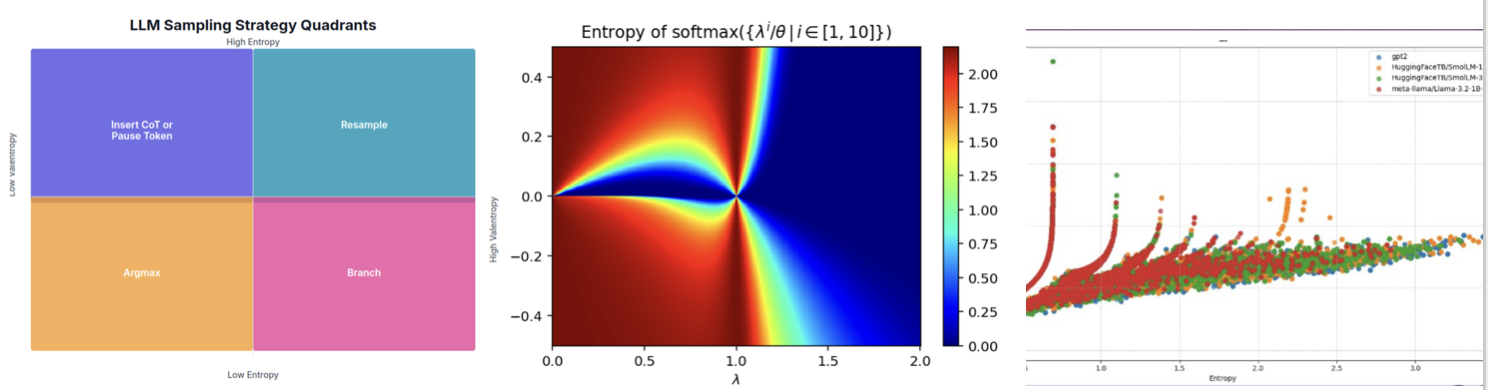This notebook aims to give a sufficient overview of text generation probabilities/sampling with LLM before catching up with all the recent cutting edge over entropy-based sampling like Entropix and the Deepmind paper "Softmax is not enough" (Veličković et al. - October 2024).

Text is focused on "deconstructing" model.generate from transformers. We'll use torch functions but sometimes replace it with custom code to dig a bit further.

While we won't directly reproduce the current setting for Entropix, the notebook gives an outloook on some of the core concepts for it. It further ends on a simpler adaptation of the adaptive temperature method from "Software is not enough" (for token sampling) so after going through it you should get up to speed for wilder stuff.

There is not prerequesite to follow on this notebook except a general familiarity with LLMs and transformers. We'll also introduce some key concepts of physic maths but in a gentle way (don't be afraid)

## Setting up the models.

First let's start with importing smollm. Nothing too fancy here:

In [ ]:
# First, let's import our required libraries
import torch
from torch.nn import functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer

# Let's use GPT-2 small for this example
model_name = "HuggingFaceTB/SmolLM-135M"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

Let's give a brief look to the overall structure of the model.

In [ ]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 576)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=576, out_features=576, bias=False)
          (k_proj): Linear(in_features=576, out_features=192, bias=False)
          (v_proj): Linear(in_features=576, out_features=192, bias=False)
          (o_proj): Linear(in_features=576, out_features=576, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=576, out_features=1536, bias=False)
          (up_proj): Linear(in_features=576, out_features=1536, bias=False)
          (down_proj): Linear(in_features=1536, out_features=576, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((576,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((576,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm

This is a llama-type model. While it uses the same structure as the llama series of model, Smollm is still an entirely new model, pretrained on a different dataset and with its own tokenizer. As you can notice there is 49152 tokens with their associated embeddings — while the current version of llama has roughly 128000 tokens. While we won't get into the inner working of the model itself, the token list and distribution will be critical for everything to come.

## Digging into the prompt sequence

We're going to start with my favorite placeholder prompt ever: the Snoopy literary meme which is decidedly a very exciting beginning. And yes good luck for the second sentence little model.

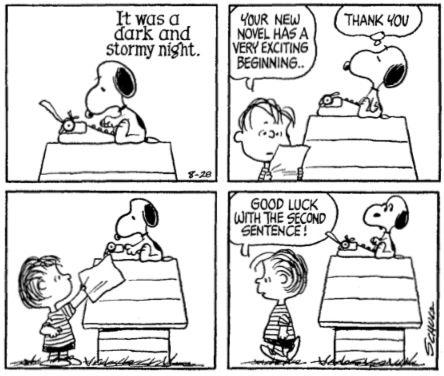


In [ ]:
# Our input prompt
prompt = "It was a dark and stormy night;" #I prefer a semicolon to steer in a more literary direction
print(f"Prompt: {prompt}")

Prompt: It was a dark and stormy night;


We start by applying the tokenizer from SmolLM. Basically we transform each part of the texts into "tokens". As it is standard English with simple words we'll simply have one word per token.

In [ ]:
input_ids = tokenizer.encode(prompt, return_tensors='pt')
input_ids = input_ids.to(device)
print(f"\nTokenized input shape: {input_ids.shape}")
print(f"Token IDs: {input_ids[0].tolist()}")
print(f"Decoded tokens: {[tokenizer.decode([id]) for id in input_ids[0].tolist()]}")


Tokenized input shape: torch.Size([1, 8])
Token IDs: [1589, 436, 253, 3605, 284, 43471, 3163, 43]
Decoded tokens: ['It', ' was', ' a', ' dark', ' and', ' stormy', ' night', ';']


Notice that the tokens have a higher value as they are associated with rarer words. ' a' (there is a space in front) is token n°253 while ' stormy' is token n°43471 — could almost have been splitted as a subword if the tokenizer was smaller or training data distribution was slightly different.

If we were writing in a non-English language, the tokens would be broken up further into *subwords* as the SmolLM tokenizer is optimized for English:



In [ ]:
french_prompt = "C'était une nuit obscure et tempêtueuse"
french_input_ids = tokenizer.encode(french_prompt, return_tensors='pt')
french_input_ids = french_input_ids.to(device)
print(f"\nTokenized input shape: {french_input_ids.shape}")
print(f"Token IDs: {french_input_ids[0].tolist()}")
print(f"Decoded tokens: {[tokenizer.decode([id]) for id in french_input_ids[0].tolist()]}")


Tokenized input shape: torch.Size([1, 14])
Token IDs: [51, 23, 19380, 2889, 16520, 304, 4637, 18702, 1482, 10321, 22069, 100, 546, 1726]
Decoded tokens: ['C', "'", 'ét', 'ait', ' une', ' n', 'uit', ' obscure', ' et', ' temp', 'ê', 't', 'ue', 'use']


Now let's predict the next words. As we go *raw*, we'll use the torch backend directly.

In [ ]:
with torch.no_grad():
  outputs = model(input_ids)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


What is inside of outputs? Just a word? No **a lot** of information:

In [ ]:
outputs

CausalLMOutputWithPast(loss=None, logits=tensor([[[ 14.2227,   2.9400,   2.8643,  ...,   9.5122,   9.8202,   8.5703],
         [  5.1251,  -6.0031,  -6.0680,  ...,  -1.8780,   2.5660,  -1.1478],
         [  4.5793,  -6.6676,  -6.8528,  ...,  -2.7242,   0.5844,  -3.2728],
         ...,
         [  1.7322, -11.9006, -11.8047,  ...,  -6.6125,  -2.6391, -10.9415],
         [ 15.3847,  -0.4590,  -0.5556,  ...,   2.8020,   9.4662,   2.7162],
         [  2.7364, -10.7625, -10.8629,  ...,  -6.8668,   0.3481,  -6.6950]]],
       device='cuda:0'), past_key_values=((tensor([[[[ 0.0207,  0.8622, -0.6651,  ...,  0.3362,  0.2586, -0.3173],
          [-1.2846, -0.3447, -0.5977,  ..., -0.0144,  0.0274, -0.1167],
          [-1.3420, -1.6957, -0.7586,  ...,  0.2375,  0.3204, -0.4201],
          ...,
          [ 0.2815, -0.4210, -0.0163,  ..., -0.0701, -0.0937,  0.2536],
          [ 0.1370, -0.0114, -0.1410,  ..., -0.2753, -0.3077,  0.3971],
          [-1.5663,  2.7301,  1.4706,  ...,  1.1341,  1.2896, -

Many of theses values are for internal processing by the model itself and we can disregard it in the scope of this notebook. What we really need to access is the predicted probabilities of the tokens: the *logits*.

In [ ]:
outputs.logits

tensor([[[ 14.2227,   2.9400,   2.8643,  ...,   9.5122,   9.8202,   8.5703],
         [  5.1251,  -6.0031,  -6.0680,  ...,  -1.8780,   2.5660,  -1.1478],
         [  4.5793,  -6.6676,  -6.8528,  ...,  -2.7242,   0.5844,  -3.2728],
         ...,
         [  1.7322, -11.9006, -11.8047,  ...,  -6.6125,  -2.6391, -10.9415],
         [ 15.3847,  -0.4590,  -0.5556,  ...,   2.8020,   9.4662,   2.7162],
         [  2.7364, -10.7625, -10.8629,  ...,  -6.8668,   0.3481,  -6.6950]]],
       device='cuda:0')

The logits is a nested list with the following nested structure:
* It is first a list of **batches** or **parallel predictions**. Basically the idea is let the model process different tokens/direction of text generation. To keep it simple we will disregard it entirely for this demo by focusing only one linear dimension of text generation.
* Each batch contains a sequence of **submitted or generated tokens**. In this case what we have is just our list of 8 tokens plus a new potential token we still to decode, so nine tokens in all.
* Each token contain the **logits for each of the tokens in the tokenizer**. You can think of it as a grade where we assess how close the token is to the full list of tokens the model can predict.

Since, we have just one batch now, let's ignore that:

In [ ]:
token_logits = outputs.logits[0]
for token_logit in token_logits:
  print(token_logit)

print(f"Total number of logits: {len(token_logits)}")

tensor([14.2227,  2.9400,  2.8643,  ...,  9.5122,  9.8202,  8.5703],
       device='cuda:0')
tensor([ 5.1251, -6.0031, -6.0680,  ..., -1.8780,  2.5660, -1.1478],
       device='cuda:0')
tensor([ 4.5793, -6.6676, -6.8528,  ..., -2.7242,  0.5844, -3.2728],
       device='cuda:0')
tensor([ 4.7838, -5.6776, -5.5700,  ...,  0.9313,  2.5597, -4.6752],
       device='cuda:0')
tensor([10.5949, -2.7195, -2.7925,  ...,  2.7901,  5.0258,  1.5130],
       device='cuda:0')
tensor([  1.7322, -11.9006, -11.8047,  ...,  -6.6125,  -2.6391, -10.9415],
       device='cuda:0')
tensor([15.3847, -0.4590, -0.5556,  ...,  2.8020,  9.4662,  2.7162],
       device='cuda:0')
tensor([  2.7364, -10.7625, -10.8629,  ...,  -6.8668,   0.3481,  -6.6950],
       device='cuda:0')
Total number of logits: 8


So here we have 8 logits but notice actually they predict the **next token**.So there is no logits predicting *It* and the last list of logits predict the new mystery token, which makes it nine words in all. So we would understand our logits in this way:

In [ ]:
decoded_tokens = [tokenizer.decode([id]) for id in input_ids[0].tolist()]
decoded_tokens = decoded_tokens[1:] #We drop the first token and append our mystery token.
decoded_tokens.append("[Mystery token]")

token_logits = outputs.logits[0]
for token, token_logit in zip(decoded_tokens, token_logits):
  print(f"Logits for '{token}'")
  print(token_logit)

Logits for ' was'
tensor([14.2227,  2.9400,  2.8643,  ...,  9.5122,  9.8202,  8.5703],
       device='cuda:0')
Logits for ' a'
tensor([ 5.1251, -6.0031, -6.0680,  ..., -1.8780,  2.5660, -1.1478],
       device='cuda:0')
Logits for ' dark'
tensor([ 4.5793, -6.6676, -6.8528,  ..., -2.7242,  0.5844, -3.2728],
       device='cuda:0')
Logits for ' and'
tensor([ 4.7838, -5.6776, -5.5700,  ...,  0.9313,  2.5597, -4.6752],
       device='cuda:0')
Logits for ' stormy'
tensor([10.5949, -2.7195, -2.7925,  ...,  2.7901,  5.0258,  1.5130],
       device='cuda:0')
Logits for ' night'
tensor([  1.7322, -11.9006, -11.8047,  ...,  -6.6125,  -2.6391, -10.9415],
       device='cuda:0')
Logits for ';'
tensor([15.3847, -0.4590, -0.5556,  ...,  2.8020,  9.4662,  2.7162],
       device='cuda:0')
Logits for '[Mystery token]'
tensor([  2.7364, -10.7625, -10.8629,  ...,  -6.8668,   0.3481,  -6.6950],
       device='cuda:0')


So let's look more closely at the mystery tokens. As we mentioned previously what we have is the complete list of logits for each of the 49152 tokens in our model.

In [ ]:
mystery_token_logits = token_logits[-1]
print(f"Length of logits for the mystery token: {len(mystery_token_logits)}")
mystery_token_logits

Length of logits for the mystery token: 49152


tensor([  2.7364, -10.7625, -10.8629,  ...,  -6.8668,   0.3481,  -6.6950],
       device='cuda:0')

Since we associate each logit to a token in our tokenizer let's make it a bit more intuitive by recovering this information.

In [ ]:
import pandas as pd
token_data = []

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    token_data.append((token_id, token, logit))

df = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit'])

df

,Token ID,Token,Logit
0,0,<|endoftext|>,2.736412
1,1,<|im_start|>,-10.762543
2,2,<|im_end|>,-10.862947
3,3,<repo_name>,-10.735880
4,4,<reponame>,-10.699675
...,...,...,...
49147,49147,Lif,-7.238016
49148,49148,omia,-11.147733
49149,49149,exfol,-6.866794
49150,49150,Mama,0.348123


Among the value we can see, it's somewhat probable that the text could just end here (<|endoftext|> is the special token to stop generating). All the rest of the suggestions are not that likely. Let's order our dataset to get a closer look.

In [ ]:
df.sort_values(by='Logit', ascending=False)

,Token ID,Token,Logit
260,260,the,11.178051
284,284,and,10.687122
357,357,it,9.726426
253,253,a,9.663482
339,339,I,9.429564
...,...,...,...
7786,7786,ikipedia,-14.316153
23166,23166,atican,-14.341627
39464,39464,inez,-14.357329
19042,19042,Leban,-14.440641


Most probable token is "the". Other candidates are mostly syntax words which makes sense since after the semicolon we are opening a new part of the sentence. Least probably tokens are very specific concepts (including the cut subword of Wikipedia), so unlikely to appear here.

As you can immediately notice the logits are **not normalized**. They can be either positive or negative values and there are no clear upper bounds. In effects, theses values change significantly from one part of the sentence to another.

To get a clearer idea let's make a counterfactual about what could have been a good alternative to *night* in our sentence.

In [ ]:
night_token_logits = token_logits[5] #We select the sixth token.
nighttoken_data = []

#We iterate over all the tokens per id
for token_id in range(len(night_token_logits)):
    token = tokenizer.decode([token_id])
    logit = night_token_logits[token_id].item()
    nighttoken_data.append((token_id, token, logit))

pd.DataFrame(nighttoken_data, columns=['Token ID', 'Token', 'Logit']).sort_values(by='Logit', ascending=False)

,Token ID,Token,Logit
3163,3163,night,11.900723
1194,1194,day,10.832601
655,655,time,9.637710
9053,9053,evening,8.870906
4339,4339,winter,8.771324
...,...,...,...
40248,40248,serializers,-18.621866
11532,11532,efits,-18.696503
21475,21475,anners,-18.730753
24238,24238,orers,-19.023859


It turns out to be night and then other time values… Whereas if we look at an alternative to "dark" sooner in the sentence (where the model would have only "It was a") we have entire different suggestions:

In [ ]:
night_token_logits = token_logits[2] #We select the sixth token.
nighttoken_data = []

#We iterate over all the tokens per id
for token_id in range(len(night_token_logits)):
    token = tokenizer.decode([token_id])
    logit = night_token_logits[token_id].item()
    nighttoken_data.append((token_id, token, logit))

pd.DataFrame(nighttoken_data, columns=['Token ID', 'Token', 'Logit']).sort_values(by='Logit', ascending=False)

,Token ID,Token,Logit
1109,1109,great,11.848448
1035,1035,very,11.770308
655,655,time,11.278011
1123,1123,good,10.933535
986,986,long,10.845976
...,...,...,...
7786,7786,ikipedia,-10.561373
14511,14511,oolean,-10.686833
48518,48518,Intf,-10.820446
13343,13343,insic,-11.032633


As you can notice once more the range of the logits is not unform at all. And we'll need something a bit more normalized to actually run a token sampler. That's when come… the softmax.

## Softmax and normalized probabilities.

Softmax is a well-known function in physics that leverage exponentials to achieve two aims:
* Normalize all the inputs into a 0-1 probability range.
* Allocate more weights to the more probable value.

The core idea is to amplify the probability of taking the highest probability word (or words).

Obviously we'll dig deeper into the softmax function given its centrality for enhance token sampler today. But first let's get an intuitive feeling using a simple one line, the softmax function included in torch (which is *not* the standard one, but more to come later).

In [ ]:
mystery_token_logits = token_logits[-1] #We select the sixth token.
token_data = []

#We get all the softmax probabilities in one batch thanks to the torch one liner
probs = torch.nn.functional.softmax(mystery_token_logits, dim=-1)

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    prob = probs[token_id].item()
    token_data.append((token_id, token, logit, prob))

df_sorted = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit', 'Probs']).sort_values(by='Probs', ascending=False)
df_sorted

,Token ID,Token,Logit,Probs
260,260,the,11.178051,2.390426e-01
284,284,and,10.687122,1.463079e-01
357,357,it,9.726426,5.598125e-02
253,253,a,9.663482,5.256615e-02
339,339,I,9.429564,4.160225e-02
...,...,...,...,...
7786,7786,ikipedia,-14.316153,2.025272e-12
23166,23166,atican,-14.341627,1.974330e-12
39464,39464,inez,-14.357329,1.943569e-12
19042,19042,Leban,-14.440641,1.788210e-12


Here basically we have a 24% chance of getting "the" and then a 15% of chance of getting "and", and quickly below 5% for the rest. Let's visualize it:

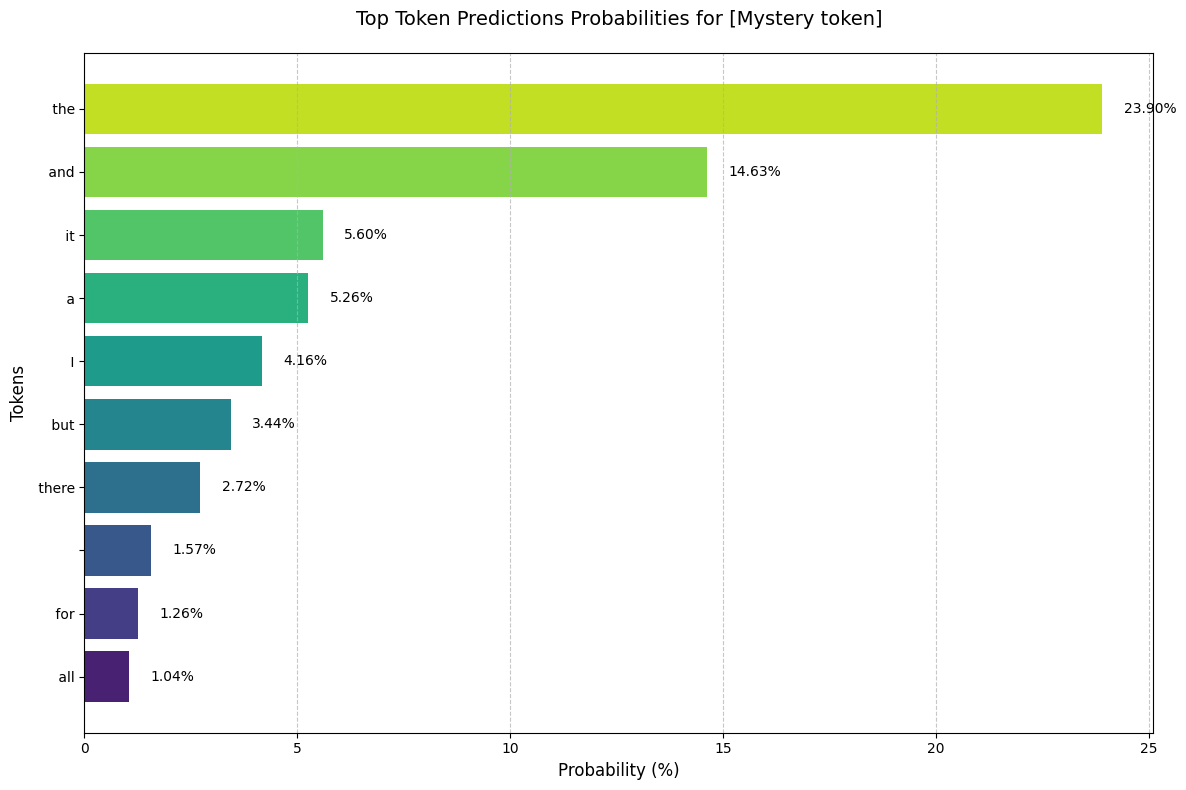

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities'):
  # Convert probabilities to percentages and get top N tokens
  N = 10  # Number of top tokens to show
  df_top = df_sorted.head(N).copy().sort_values(by='Probs', ascending=True)  # Get last N rows since we sorted ascending
  df_top['Percentage'] = df_top['Probs'] * 100  # Convert to percentage

  # Create the visualization
  plt.figure(figsize=(12, 8))

  # Create horizontal bar plot
  bars = plt.barh(df_top['Token'], df_top['Percentage'],
                  color=sns.color_palette("viridis", N))

  # Customize the plot
  plt.title(title, pad=20, fontsize=14)
  plt.xlabel('Probability (%)', fontsize=12)
  plt.ylabel('Tokens', fontsize=12)

  # Add percentage labels on the bars
  for i, bar in enumerate(bars):
      width = bar.get_width()
      plt.text(width + 0.5,
              bar.get_y() + bar.get_height()/2,
              f'{width:.2f}%',
              ha='left',
              va='center')

  # Adjust layout and grid
  plt.grid(axis='x', linestyle='--', alpha=0.7)
  plt.tight_layout()

  # Show plot
  plt.show()

visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities for [Mystery token]')

By comparison with "night" the distribution was much more clear cut as the model is nearly in auto-mode to fill in the well-known cliché phrase.

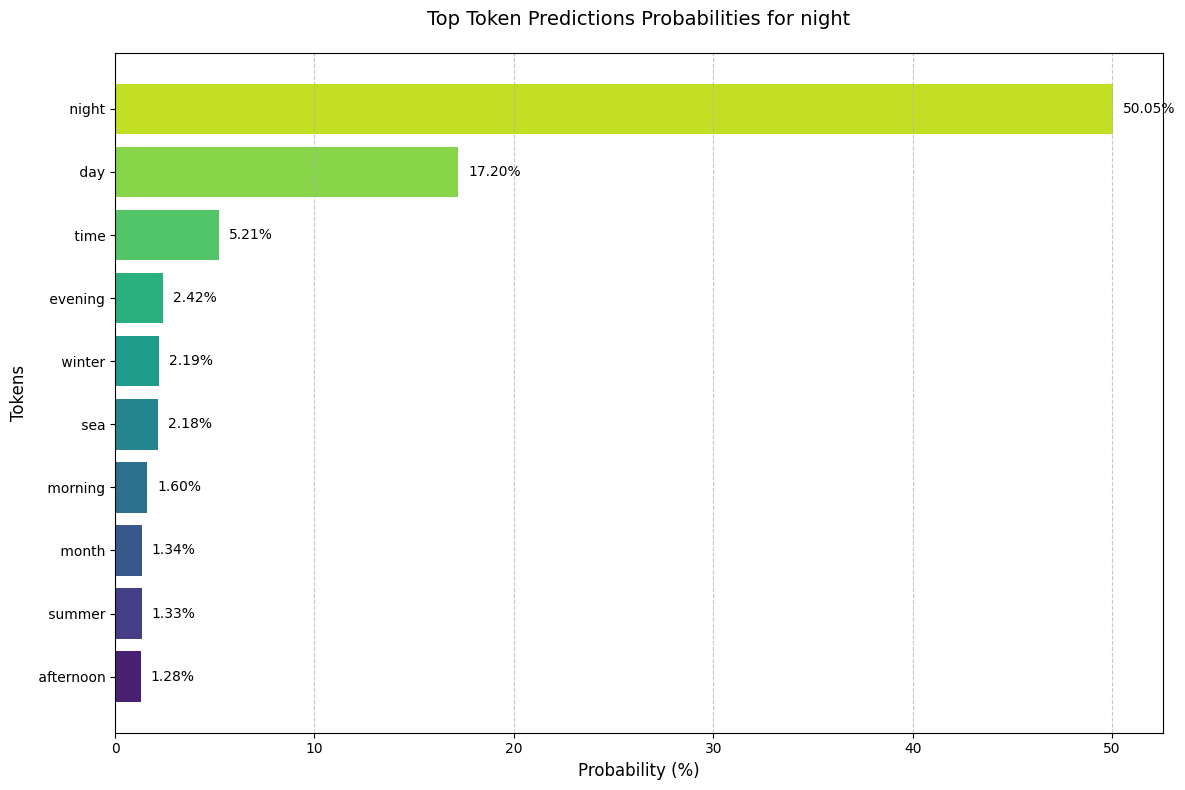

In [ ]:
mystery_token_logits = token_logits[5] #We select the sixth token.
token_data = []

#We get all the softmax probabilities in one batch thanks to the torch one liner
probs = torch.nn.functional.softmax(mystery_token_logits, dim=-1)

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    prob = probs[token_id].item()
    token_data.append((token_id, token, logit, prob))

df_sorted = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit', 'Probs']).sort_values(by='Probs', ascending=False)
visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities for night')

Finally let's compare with "dark":

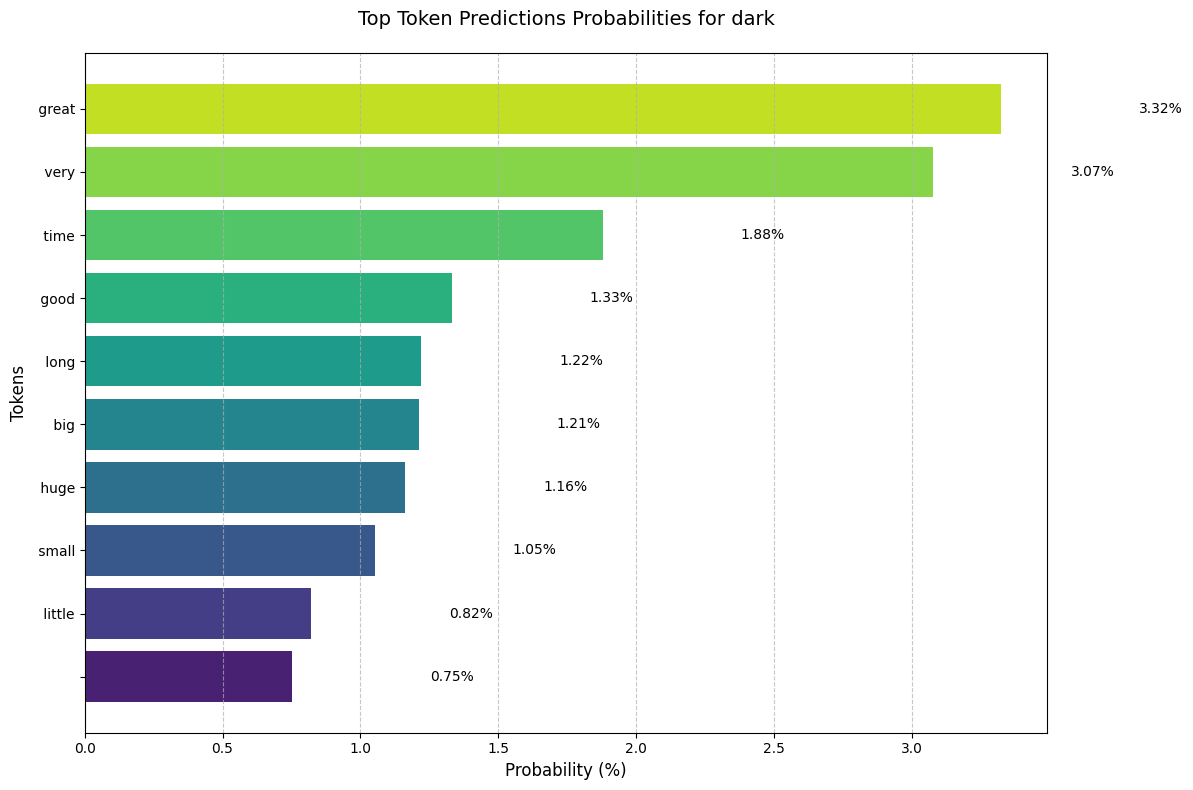

In [ ]:
mystery_token_logits = token_logits[2] #We select the sixth token.
token_data = []

#We get all the softmax probabilities in one batch thanks to the torch one liner
probs = torch.nn.functional.softmax(mystery_token_logits, dim=-1)

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    prob = probs[token_id].item()
    token_data.append((token_id, token, logit, prob))

df_sorted = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit', 'Probs']).sort_values(by='Probs', ascending=False)
visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities for dark')

There is no clear cut choice here. "Dark" does not even appear and the model could branch out in multiple directions.

This contrast is the fundamental principle for enhancing text generation: **probability distribution of each tokens is not similar**. The model is much more confident that "night" is true than "dark" is true. Projects like entropix aims to leverage this information to extrapolate better strategy of token selections.

So what does the softmax do to extrapolate this probability distribution. It relies on a modified version of the classifc Boltzmann formula: $\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$ We can implement it directly in Python with a toy set of logits:

In [ ]:
import math
def classic_softmax(logits):
    exps = [math.exp(x) for x in logits] #Get all the exponential for each logits
    sum_exps = sum(exps) #Take the sum fo the exponentials
    result = [exp/sum_exps for exp in exps] #For each exponential divide it by the exp sum to get it normalized.
    return result

#High entropy logits
sample_logits = torch.tensor([100.0, 100.1, 100.2])
sample_softmax = classic_softmax(sample_logits)
print(f"Example of softmax with high entropy: {sample_softmax}")

#Mid entropy logits
sample_logits = torch.tensor([100, 98, 102])
sample_softmax = classic_softmax(sample_logits)
print(f"Example of softmax with mid entropy: {sample_softmax}")

#Low entropy logits
sample_logits = torch.tensor([100, -80, 110])
sample_softmax = classic_softmax(sample_logits)
print(f"Example of softmax with low entropy: {sample_softmax}")

Example of softmax with high entropy: [0.30061009457848364, 0.33222502727256203, 0.3671648781489543]
Example of softmax with mid entropy: [0.11731042782619837, 0.01587623997646677, 0.8668133321973349]
Example of softmax with low entropy: [4.53978687024344e-05, 3.0480965676017788e-83, 0.9999546021312976]


Torch implements a modified version with more numeric stability using the formula $\text{softmax}(x_i) = \frac{e^{x_i - \max_j(x_j)}}{\sum_{j=1}^{n} e^{x_j - \max_j(x_j)}}$ The main motivation for it is better support for negative entries. Results are identical in our toy example:

In [ ]:
import math
def stabler_softmax(logits):
    shifted_logits = [x - max(logits) for x in logits] #Modified part where we further normalize the logits by removing the max value.
    exps = [math.exp(x) for x in shifted_logits]
    sum_exps = sum(exps)
    return [exp/sum_exps for exp in exps]

#High entropy logits
sample_logits = torch.tensor([100.0, 100.1, 100.2])
sample_softmax = stabler_softmax(sample_logits)
print(f"Example of stabler softmax with high entropy: {sample_softmax}")

#Mid entropy logits
sample_logits = torch.tensor([100, 98, 102])
sample_softmax = stabler_softmax(sample_logits)
print(f"Example of stabler softmax with mid entropy: {sample_softmax}")

#Low entropy logits
sample_logits = torch.tensor([100, -80, 110])
sample_softmax = stabler_softmax(sample_logits)
print(f"Example of stabler softmax with low entropy: {sample_softmax}")

Example of stabler softmax with high entropy: [0.30061009457848364, 0.33222502727256203, 0.3671648781489543]
Example of stabler softmax with mid entropy: [0.11731042782619838, 0.015876239976466765, 0.8668133321973349]
Example of stabler softmax with low entropy: [4.5397868702434395e-05, 3.0480965676017784e-83, 0.9999546021312976]


As you notice we have used list comprehension to calculate the softmax which is easier to understand but not… very efficient. Torch will rely directly on matrix operations so at this point no real reason to not use their own implementation.

## Adding the temperature

Like the softmax the "temperature" comes straight from math physics. It's fairly simple to add: we simply divide all the logits by this value before calculating the softmax. What this means also is that all our tests were done with a temperature of 1.0 (which is a bit higher than usual).

Let's "freeze" a bit the temperature and lower it to 0.5.

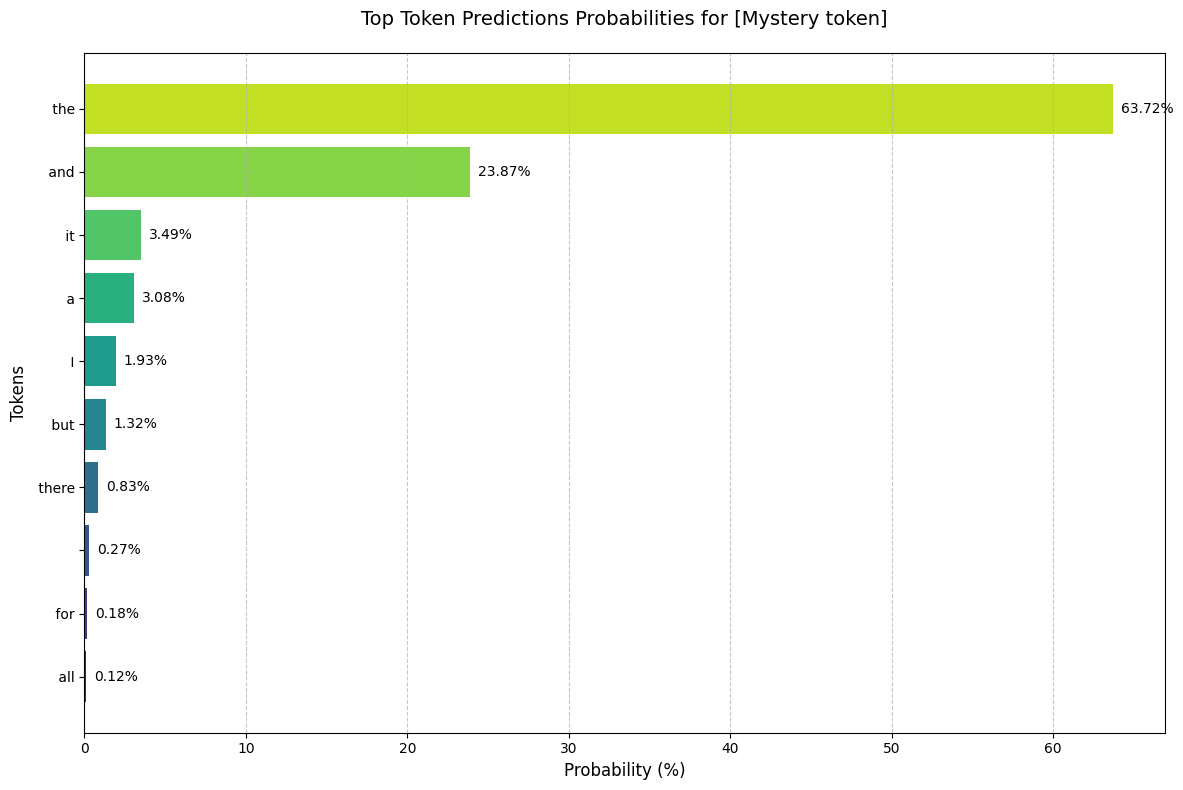

In [ ]:
temperature = 0.5
mystery_token_logits = token_logits[-1] #We select the sixth token.
token_data = []

mystery_token_logits = mystery_token_logits / temperature

#We get all the softmax probabilities in one batch thanks to the torch one liner
probs = torch.nn.functional.softmax(mystery_token_logits, dim=-1)

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    prob = probs[token_id].item()
    token_data.append((token_id, token, logit, prob))

df_sorted = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit', 'Probs']).sort_values(by='Probs', ascending=False)
visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities for [Mystery token]')

This is a very different distribution! **the** is much more likely now. **and** remains a distinct possibility while all the rest becomes much more unlikely.

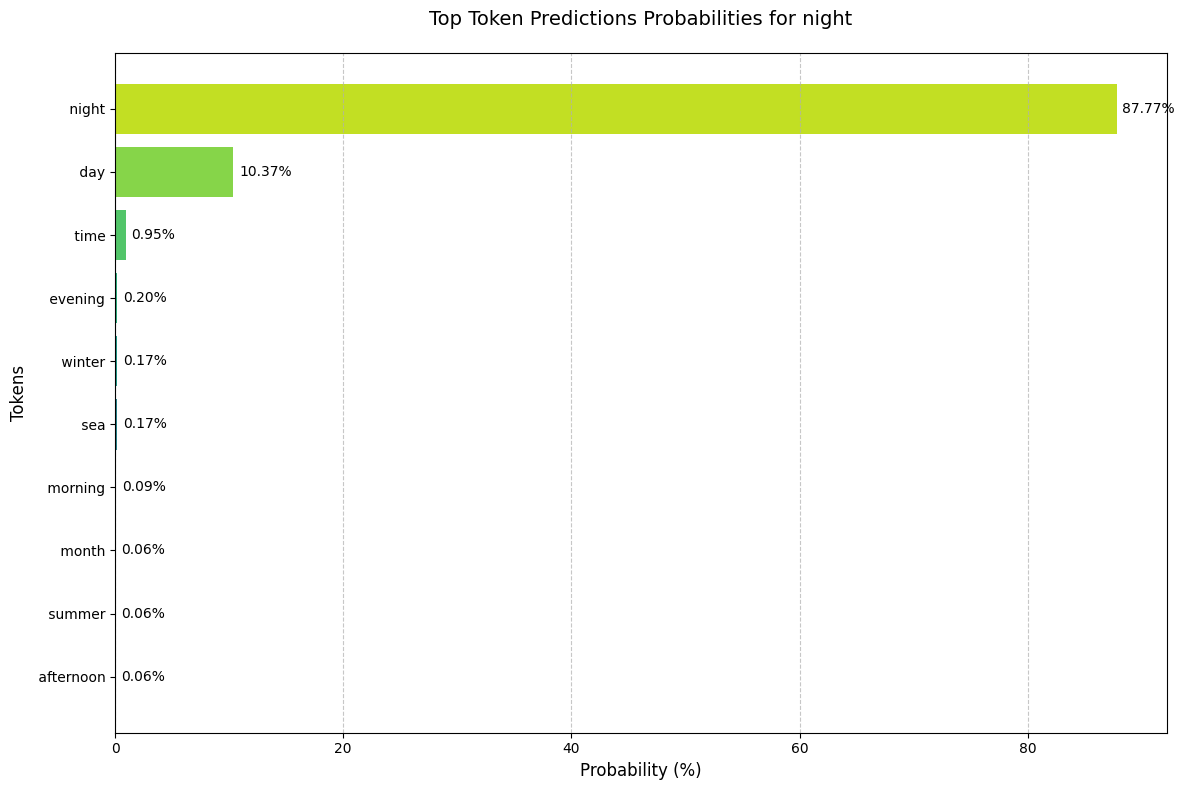

In [ ]:
temperature = 0.5
mystery_token_logits = token_logits[5] #We select the sixth token.
token_data = []

mystery_token_logits = mystery_token_logits / temperature

#We get all the softmax probabilities in one batch thanks to the torch one liner
probs = torch.nn.functional.softmax(mystery_token_logits, dim=-1)

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    prob = probs[token_id].item()
    token_data.append((token_id, token, logit, prob))

df_sorted = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit', 'Probs']).sort_values(by='Probs', ascending=False)
visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities for night')

**night** is now a near-certainty.

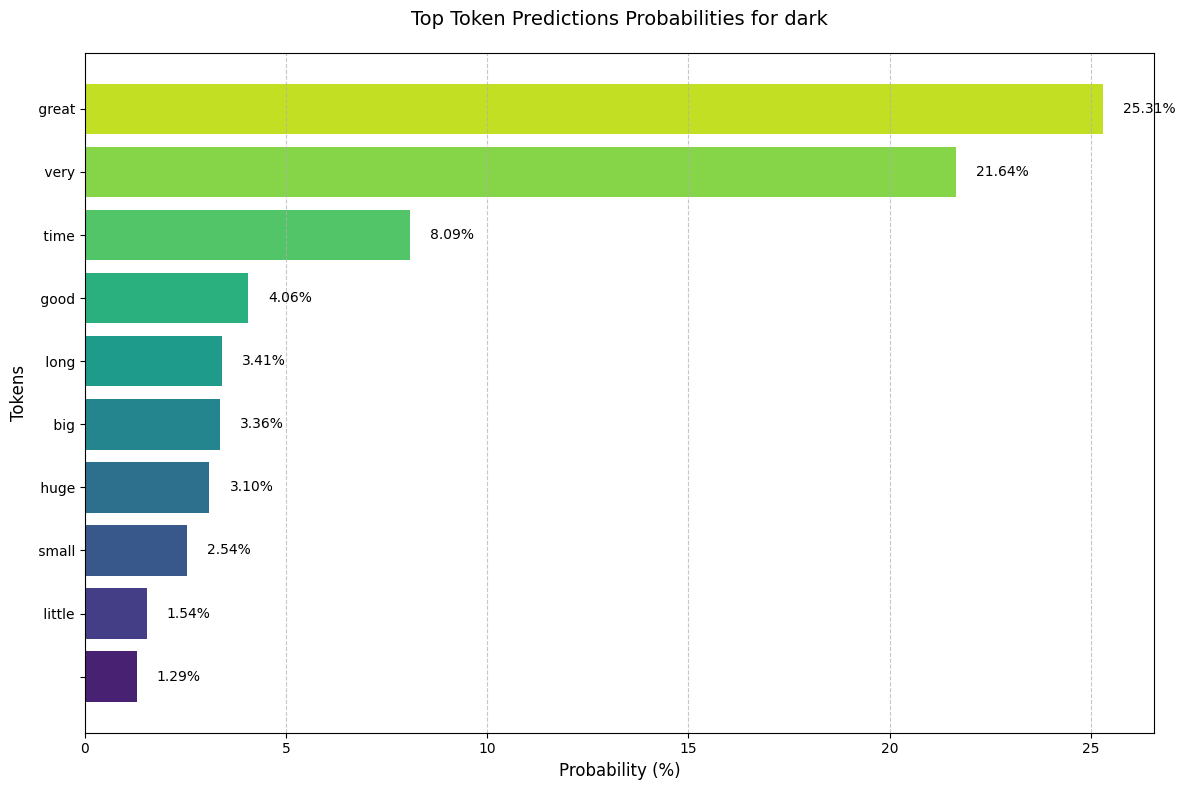

In [ ]:
temperature = 0.5
mystery_token_logits = token_logits[2] #We select the sixth token.
token_data = []

mystery_token_logits = mystery_token_logits / temperature

#We get all the softmax probabilities in one batch thanks to the torch one liner
probs = torch.nn.functional.softmax(mystery_token_logits, dim=-1)

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    prob = probs[token_id].item()
    token_data.append((token_id, token, logit, prob))

df_sorted = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit', 'Probs']).sort_values(by='Probs', ascending=False)
visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities for dark')

Alternative distribution for **dark** remains more diverse (and obviously *darl* is still nowhere in sight since the temperature does not change the ordering).

Now what happens if we set temperature to zero? Our original code will simply break since we end up with a division per zero and undetermined value for all tokens…

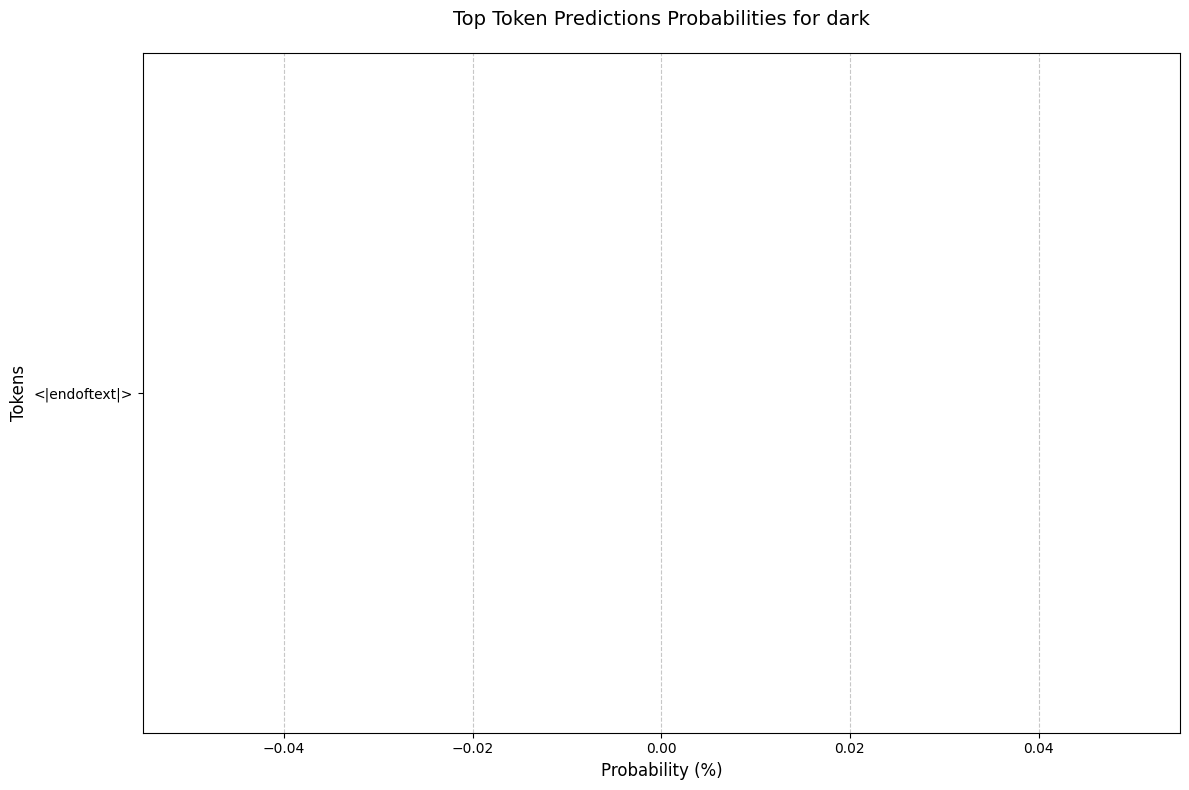

In [ ]:
temperature = 0
mystery_token_logits = token_logits[2] #We select the sixth token.
token_data = []

mystery_token_logits = mystery_token_logits / temperature

#We get all the softmax probabilities in one batch thanks to the torch one liner
probs = torch.nn.functional.softmax(mystery_token_logits, dim=-1)

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    prob = probs[token_id].item()
    token_data.append((token_id, token, logit, prob))

df_sorted = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit', 'Probs']).sort_values(by='Probs', ascending=False)
visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities for dark')

Instead the standard approach used for text generation is to include a special case: when the temperature is disabled we simply assign a 100% probability chance for the token with the highest logit. "the" is 100%, "night" is 100% and "great" (instead of "dark") is 100%.

In [ ]:
torch.cuda.empty_cache()

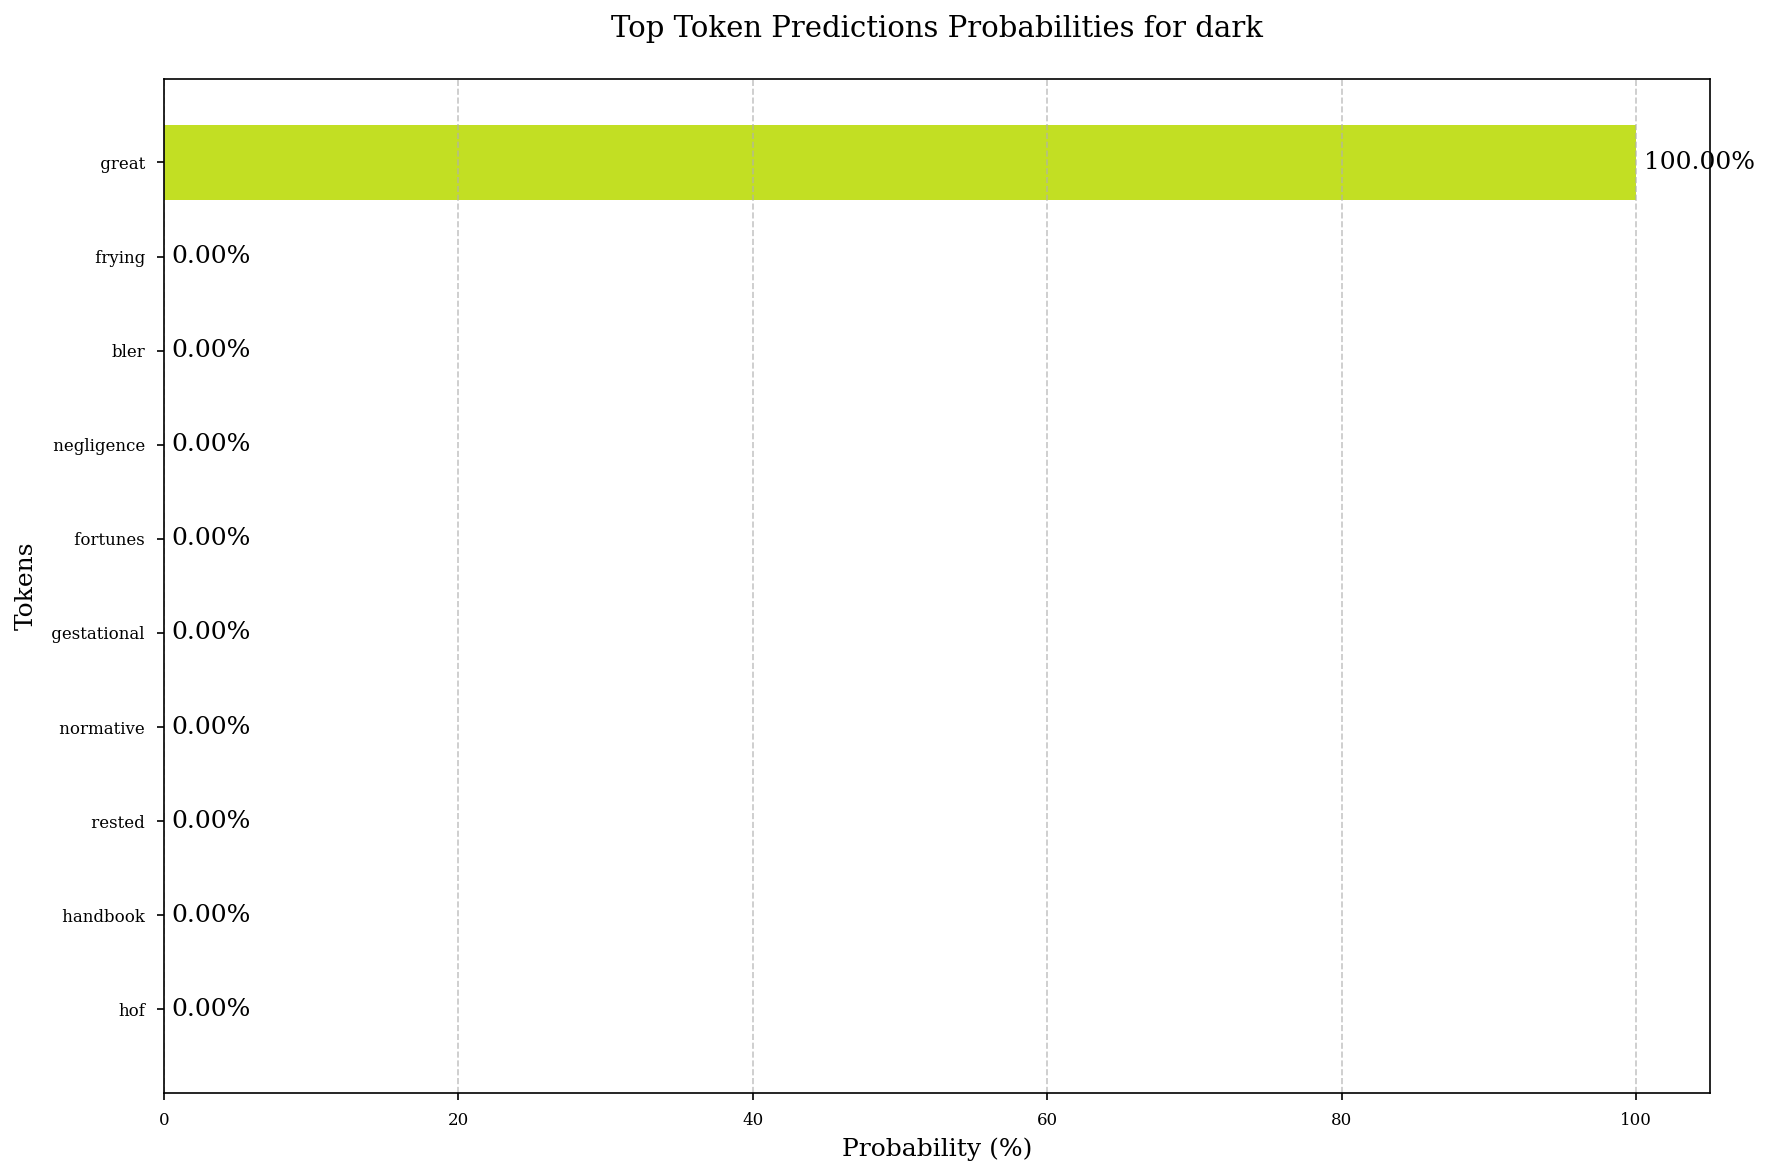

In [ ]:
temperature = 0
mystery_token_logits = token_logits[2] #We select the sixth token.
token_data = []

#We get all the softmax probabilities in one batch thanks to the torch one liner

if temperature == 0:
  max_idx = torch.argmax(mystery_token_logits)
  probs = torch.zeros_like(mystery_token_logits)
  probs[max_idx] = 1.0
else:
  mystery_token_logits = mystery_token_logits / temperature
  probs = torch.nn.functional.softmax(mystery_token_logits, dim=-1)

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    prob = probs[token_id].item()
    token_data.append((token_id, token, logit, prob))

df_sorted = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit', 'Probs']).sort_values(by='Probs', ascending=False)
visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities for dark')

As you notice we just get pure random suggestions (set to 0) instead of the one token retained.

At this point we have everything we need to create an entirely new sequence of text. I'll simply swap our previous code with more torch-based functions to make it a bit less painfully long to compute.

We'll introduce a new concept here: the length (total length of the text including the input afterwards generation will stop).

In [ ]:
max_length = 20 #Including our 20 tokens.
temperature = 1
top_tokens = 5 #number of top tokens to highlight.

Additionally to make the generation reproducible, I'll set up multiple seeds in pytorch (and yes, there's a lot of stochasticity involved in LLMs…)

In [ ]:
import random
import numpy as np

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

And now let's launch the actual generation:

In [ ]:
new_prediction_ids = input_ids
# Set the seeds
set_seeds(42)

cur_len = new_prediction_ids.shape[1]
while cur_len < max_length:
    with torch.no_grad():
        outputs = model(new_prediction_ids)

    #Extract the logits.
    next_token_logits = outputs.logits[:, -1, :]

    #Apply the temperature and the softmax
    next_token_logits = next_token_logits / temperature
    probs = F.softmax(next_token_logits, dim=-1)

    # Get top_k tokens and their probabilities before sampling
    top_logits, top_indices = torch.topk(next_token_logits, top_tokens)

    # Sample the next token
    next_token = torch.multinomial(probs, num_samples=1,)

    # Find the rank of the sampled token
    sorted_indices = torch.argsort(probs[0], descending=True)
    sampled_token_rank = (sorted_indices == next_token[0].item()).nonzero().item() + 1

    print(f"\nTop {top_tokens} candidates at position {cur_len}:")
    for logit, idx in zip(top_logits[0], top_indices[0]):
        token = tokenizer.decode([idx])
        prob = probs[0, idx].item()
        print(f"Token: '{token}', Probability: {prob:.4f}")

    # What was actually selected:
    print(f"\nSelected token: '{tokenizer.decode([next_token[0].item()])}' (Rank: {sampled_token_rank})")

    # Add the new token to our sequence
    new_prediction_ids = torch.cat([new_prediction_ids, next_token], dim=-1)
    cur_len += 1

    print(f"Current text: {tokenizer.decode(new_prediction_ids[0])}")

print(f"\nFinal generated text:")
print(tokenizer.decode(new_prediction_ids[0]))


Top 5 candidates at position 8:
Token: ' the', Probability: 0.2390
Token: ' and', Probability: 0.1463
Token: ' it', Probability: 0.0560
Token: ' a', Probability: 0.0526
Token: ' I', Probability: 0.0416

Selected token: ' if' (Rank: 89)
Current text: It was a dark and stormy night; if

Top 5 candidates at position 9:
Token: ' I', Probability: 0.1901
Token: ' you', Probability: 0.1391
Token: ' the', Probability: 0.0989
Token: ' it', Probability: 0.0681
Token: ' a', Probability: 0.0507

Selected token: ' the' (Rank: 3)
Current text: It was a dark and stormy night; if the

Top 5 candidates at position 10:
Token: ' moon', Probability: 0.0673
Token: ' sun', Probability: 0.0625
Token: ' sky', Probability: 0.0475
Token: ' wind', Probability: 0.0366
Token: ' stars', Probability: 0.0255

Selected token: ' Moon' (Rank: 20)
Current text: It was a dark and stormy night; if the Moon

Top 5 candidates at position 11:
Token: ' had', Probability: 0.2715
Token: ' were', Probability: 0.2143
Token: ' was

What you can immediately notice:
* The first most probable token is not necessarily the one taken. That's why we get an actual stochastic parrot: at each moment while the most probable token is favored, nothing prevent a lesser probable one to get select.
* Consequently a lower or higher temperature will make it less or more likely to select the more favored tokens or to explore alternative directions.
* "Critical" moment in the text with have a flater distribution. This is the part the current generation of samplers aims to solve better by giving the LLM more ability to optimize on the different paths. You can notice here that "Dark" at the start of the new sentence is especially low (rank 179) as it is a high inflection point.

If we rerun the sequence with a higher temperature we can get significantly different results:

In [ ]:
new_prediction_ids = input_ids
# Set the seeds
set_seeds(42)
temperature = 1.5

cur_len = new_prediction_ids.shape[1]
while cur_len < max_length:
    with torch.no_grad():
        outputs = model(new_prediction_ids)

    #Extract the logits.
    next_token_logits = outputs.logits[:, -1, :]

    #Apply the temperature and the softmax
    next_token_logits = next_token_logits / temperature
    probs = F.softmax(next_token_logits, dim=-1)

    # Get top_k tokens and their probabilities before sampling
    top_logits, top_indices = torch.topk(next_token_logits, top_tokens)

    # Sample the next token
    next_token = torch.multinomial(probs, num_samples=1)

    # Find the rank of the sampled token
    sorted_indices = torch.argsort(probs[0], descending=True)
    sampled_token_rank = (sorted_indices == next_token[0].item()).nonzero().item() + 1

    print(f"\nTop {top_tokens} candidates at position {cur_len}:")
    for logit, idx in zip(top_logits[0], top_indices[0]):
        token = tokenizer.decode([idx])
        prob = probs[0, idx].item()
        print(f"Token: '{token}', Probability: {prob:.4f}")

    # What was actually selected:
    print(f"\nSelected token: '{tokenizer.decode([next_token[0].item()])}' (Rank: {sampled_token_rank})")

    # Add the new token to our sequence
    new_prediction_ids = torch.cat([new_prediction_ids, next_token], dim=-1)
    cur_len += 1

    print(f"Current text: {tokenizer.decode(new_prediction_ids[0])}")

print(f"\nFinal generated text:")
print(tokenizer.decode(new_prediction_ids[0]))


Top 5 candidates at position 8:
Token: ' the', Probability: 0.0510
Token: ' and', Probability: 0.0368
Token: ' it', Probability: 0.0194
Token: ' a', Probability: 0.0186
Token: ' I', Probability: 0.0159

Selected token: ' Daniel' (Rank: 776)
Current text: It was a dark and stormy night; Daniel

Top 5 candidates at position 9:
Token: ' was', Probability: 0.0434
Token: ' and', Probability: 0.0263
Token: ' had', Probability: 0.0208
Token: ',', Probability: 0.0157
Token: ''s', Probability: 0.0154

Selected token: 'mac' (Rank: 3624)
Current text: It was a dark and stormy night; Danielmac

Top 5 candidates at position 10:
Token: ' was', Probability: 0.0177
Token: ',', Probability: 0.0137
Token: 'don', Probability: 0.0104
Token: 'g', Probability: 0.0099
Token: ' said', Probability: 0.0077

Selected token: ' pledged' (Rank: 899)
Current text: It was a dark and stormy night; Danielmac pledged

Top 5 candidates at position 11:
Token: ' his', Probability: 0.0745
Token: ' to', Probability: 0.0723


Most of the tokens have a very low ranks as distribution are highly flat and there is no obvious sense of direction. If we go back to a low temperature we'll get:

In [ ]:
new_prediction_ids = input_ids
# Set the seeds
set_seeds(42)
temperature = 0.5

cur_len = new_prediction_ids.shape[1]
while cur_len < max_length:
    with torch.no_grad():
        outputs = model(new_prediction_ids)

    #Extract the logits.
    next_token_logits = outputs.logits[:, -1, :]

    #Apply the temperature and the softmax
    next_token_logits = next_token_logits / temperature
    probs = F.softmax(next_token_logits, dim=-1)

    # Get top_k tokens and their probabilities before sampling
    top_logits, top_indices = torch.topk(next_token_logits, top_tokens)

    # Sample the next token
    next_token = torch.multinomial(probs, num_samples=1)

    # Find the rank of the sampled token
    sorted_indices = torch.argsort(probs[0], descending=True)
    sampled_token_rank = (sorted_indices == next_token[0].item()).nonzero().item() + 1

    print(f"\nTop {top_tokens} candidates at position {cur_len}:")
    for logit, idx in zip(top_logits[0], top_indices[0]):
        token = tokenizer.decode([idx])
        prob = probs[0, idx].item()
        print(f"Token: '{token}', Probability: {prob:.4f}")

    # What was actually selected:
    print(f"\nSelected token: '{tokenizer.decode([next_token[0].item()])}' (Rank: {sampled_token_rank})")

    # Add the new token to our sequence
    new_prediction_ids = torch.cat([new_prediction_ids, next_token], dim=-1)
    cur_len += 1

    print(f"Current text: {tokenizer.decode(new_prediction_ids[0])}")

print(f"\nFinal generated text:")
print(tokenizer.decode(new_prediction_ids[0]))


Top 5 candidates at position 8:
Token: ' the', Probability: 0.6372
Token: ' and', Probability: 0.2387
Token: ' it', Probability: 0.0349
Token: ' a', Probability: 0.0308
Token: ' I', Probability: 0.0193

Selected token: ' and' (Rank: 2)
Current text: It was a dark and stormy night; and

Top 5 candidates at position 9:
Token: ' the', Probability: 0.6748
Token: ' I', Probability: 0.1456
Token: ' there', Probability: 0.0782
Token: ' yet', Probability: 0.0256
Token: ' as', Probability: 0.0137

Selected token: ' the' (Rank: 1)
Current text: It was a dark and stormy night; and the

Top 5 candidates at position 10:
Token: ' moon', Probability: 0.4951
Token: ' sky', Probability: 0.0861
Token: ' wind', Probability: 0.0818
Token: ' sun', Probability: 0.0624
Token: ' clouds', Probability: 0.0298

Selected token: ' moon' (Rank: 1)
Current text: It was a dark and stormy night; and the moon

Top 5 candidates at position 11:
Token: ' was', Probability: 0.7744
Token: ' shone', Probability: 0.0832
Toke

We can notice that now most of the time the top ranks word are taken.

## From global temperature to adaptative temperature.

Current frameworks for text generation apply a uniform temperature. The text will have a low or a high variability throughout the text generation phase. Yet this does not mirror very well how text are written. Frequently a writer will alternate between phases of semi-automated suggestions (like the "dark and stormy night" cliché) and more original turning points. A more elegant solution would be to implement an "adaptive temperature", changing from tokens to tokens based on some feedback, typically the degree of confidence the model can have in its own generations.

Strategies for adaptative temperature based on entropy distribution were simultaneously introduced by the Entropix project and the Deepmind publication "softmax is not enough (for sharp out-of-distribution)" in October 2024. For the purpose of this demo we are going to take inspiration the Deepmind approach, while making a simpler version for logits rather than attention heads.

To get an initial grasp of the concept, let's calculate the Shannon entropy over different set of logits in our short text.

In [ ]:
def compute_entropy(probs):
    """
    Compute Shannon entropy of probability distribution
    """
    return -torch.sum(probs * torch.log(probs + 1e-9)) #We add a very small value to avoid 0s.

print("Entropy value for [Mystery token]:")
mystery_token_logits = token_logits[-1]
print(f"{compute_entropy(torch.nn.functional.softmax(mystery_token_logits, dim=-1)):.3f}")

print("Entropy value for night:")
mystery_token_logits = token_logits[5]
print(f"{compute_entropy(torch.nn.functional.softmax(mystery_token_logits, dim=-1)):.3f}")

print("Entropy value for dark:")
mystery_token_logits = token_logits[2]
print(f"{compute_entropy(torch.nn.functional.softmax(mystery_token_logits, dim=-1)):.3f}")

Entropy value for [Mystery token]:
4.087
Entropy value for night:
2.452
Entropy value for dark:
7.121


As we can immediately see the entropy matches our "gut" feeling while seeing the token distribution: it is lower when probabilities are highly concentrated on one token and higher when they are dispersed (case for "dark").

Veličković et al. designed a method to deduce an optimal temperature value based on the logits. It is a degree-4 function using the following coefficients for their internal tested model: $\theta \approx \frac{1}{-1.791 + 4.917H - 2.3H^2 + 0.481H^3 - 0.037H^4}$

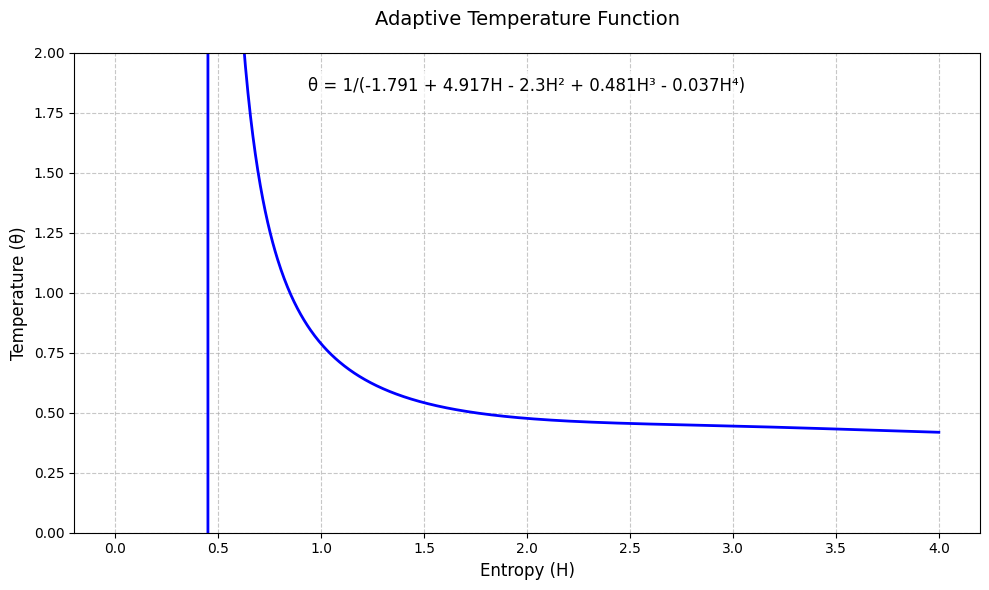

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Explicitly disable LaTeX
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

def temperature_function(H):
    """Calculate temperature based on entropy H"""
    return 1 / (-1.791 + 4.917*H - 2.3*H**2 + 0.481*H**3 - 0.037*H**4)

# Create data points
H = np.linspace(0, 4, 1000)
theta = temperature_function(H)

# First plot: Clean visualization of the function
plt.figure(figsize=(10, 6))

# Plot the function
plt.plot(H, theta, 'b-', linewidth=2)

# Add title and labels
plt.title('Adaptive Temperature Function', fontsize=14, pad=20)
plt.xlabel('Entropy (H)', fontsize=12)
plt.ylabel('Temperature (θ)', fontsize=12)

# Add the equation as text with regular text (no LaTeX)
equation = 'θ = 1/(-1.791 + 4.917H - 2.3H² + 0.481H³ - 0.037H⁴)'
plt.text(0.5, 0.95, equation,
        transform=plt.gca().transAxes,
        horizontalalignment='center',
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
        fontsize=12)

# Customize grid
plt.grid(True, linestyle='--', alpha=0.7)

# Set reasonable y-axis limits
plt.ylim(0, 2)

# Add some padding to the layout
plt.tight_layout()

# Show the plot
plt.show()

Could the same coefficient works out for smollm? Let's give it a try.

Notice that the polynomial output ("beta") is not yielding directly the temperature its inverse.

In [ ]:
poly_coeffs = torch.tensor([-0.037, 0.481, -2.3, 4.917, -1.791])

print("[Mystery token]:")
logits = token_logits[-1]
logits_cpu = logits.cpu() if logits.is_cuda else logits
x = compute_entropy(torch.nn.functional.softmax(logits, dim=-1))
beta = (poly_coeffs[0] * x**4 + poly_coeffs[1] * x**3 + poly_coeffs[2] * x**2 + poly_coeffs[3] * x + poly_coeffs[4])
if x <= 0.5:
  beta = 1.0
else:
  beta = max(beta, 1.0)
print("Entropy - " + str(x) + ", Beta - " + str(beta) + ", Inferred temperature - " + str(1/beta))

print("night:")
logits = token_logits[5]
logits_cpu = logits.cpu() if logits.is_cuda else logits
x = compute_entropy(torch.nn.functional.softmax(logits, dim=-1))
beta = (poly_coeffs[0] * x**4 + poly_coeffs[1] * x**3 + poly_coeffs[2] * x**2 + poly_coeffs[3] * x + poly_coeffs[4])
if x <= 0.5:
  beta = 1.0
else:
  beta = max(beta, 1.0)
print("Entropy - " + str(x) + ", Beta - " + str(beta) + ", Inferred temperature - " + str(1/beta))

print("dark:")
logits = token_logits[2]
logits_cpu = logits.cpu() if logits.is_cuda else logits
x = compute_entropy(torch.nn.functional.softmax(logits, dim=-1))
beta = (poly_coeffs[0] * x**4 + poly_coeffs[1] * x**3 + poly_coeffs[2] * x**2 + poly_coeffs[3] * x + poly_coeffs[4])
if x <= 0.5:
  beta = 1.0
else:
  beta = max(beta, 1.0)
print("Entropy - " + str(x) + ", Beta - " + str(beta) + ", Inferred temperature - " + str(1/beta))

[Mystery token]:
Entropy - tensor(4.0872, device='cuda:0'), Beta - tensor(2.3999, device='cuda:0'), Inferred temperature - tensor(0.4167, device='cuda:0')
night:
Entropy - tensor(2.4519, device='cuda:0'), Beta - tensor(2.1907, device='cuda:0'), Inferred temperature - tensor(0.4565, device='cuda:0')
dark:
Entropy - tensor(7.1215, device='cuda:0'), Beta - 1.0, Inferred temperature - 1.0


It seems to… The overall principle is working: we risk a higher temperature when the model is less confident to explore more alternative paths. Temperature is ceiled to not be higher than 1.0 whenever entropy is too high.

Let's run now some predictions.

In [ ]:
def adaptive_temperature_softmax(logits):
    """
    Implement adaptive temperature softmax based on entropy
    """
    logits_cpu = logits.cpu() if logits.is_cuda else logits
    x = compute_entropy(torch.nn.functional.softmax(logits, dim=-1))
    beta = (poly_coeffs[0] * x**4 + poly_coeffs[1] * x**3 + poly_coeffs[2] * x**2 + poly_coeffs[3] * x + poly_coeffs[4])
    if x <= 0.5:
      beta = 1.0
    else:
      beta = max(beta, 1.0)
    adaptive_logits = torch.nn.functional.softmax(logits * beta, dim=-1)
    temperature = 1/beta
    return adaptive_logits, temperature


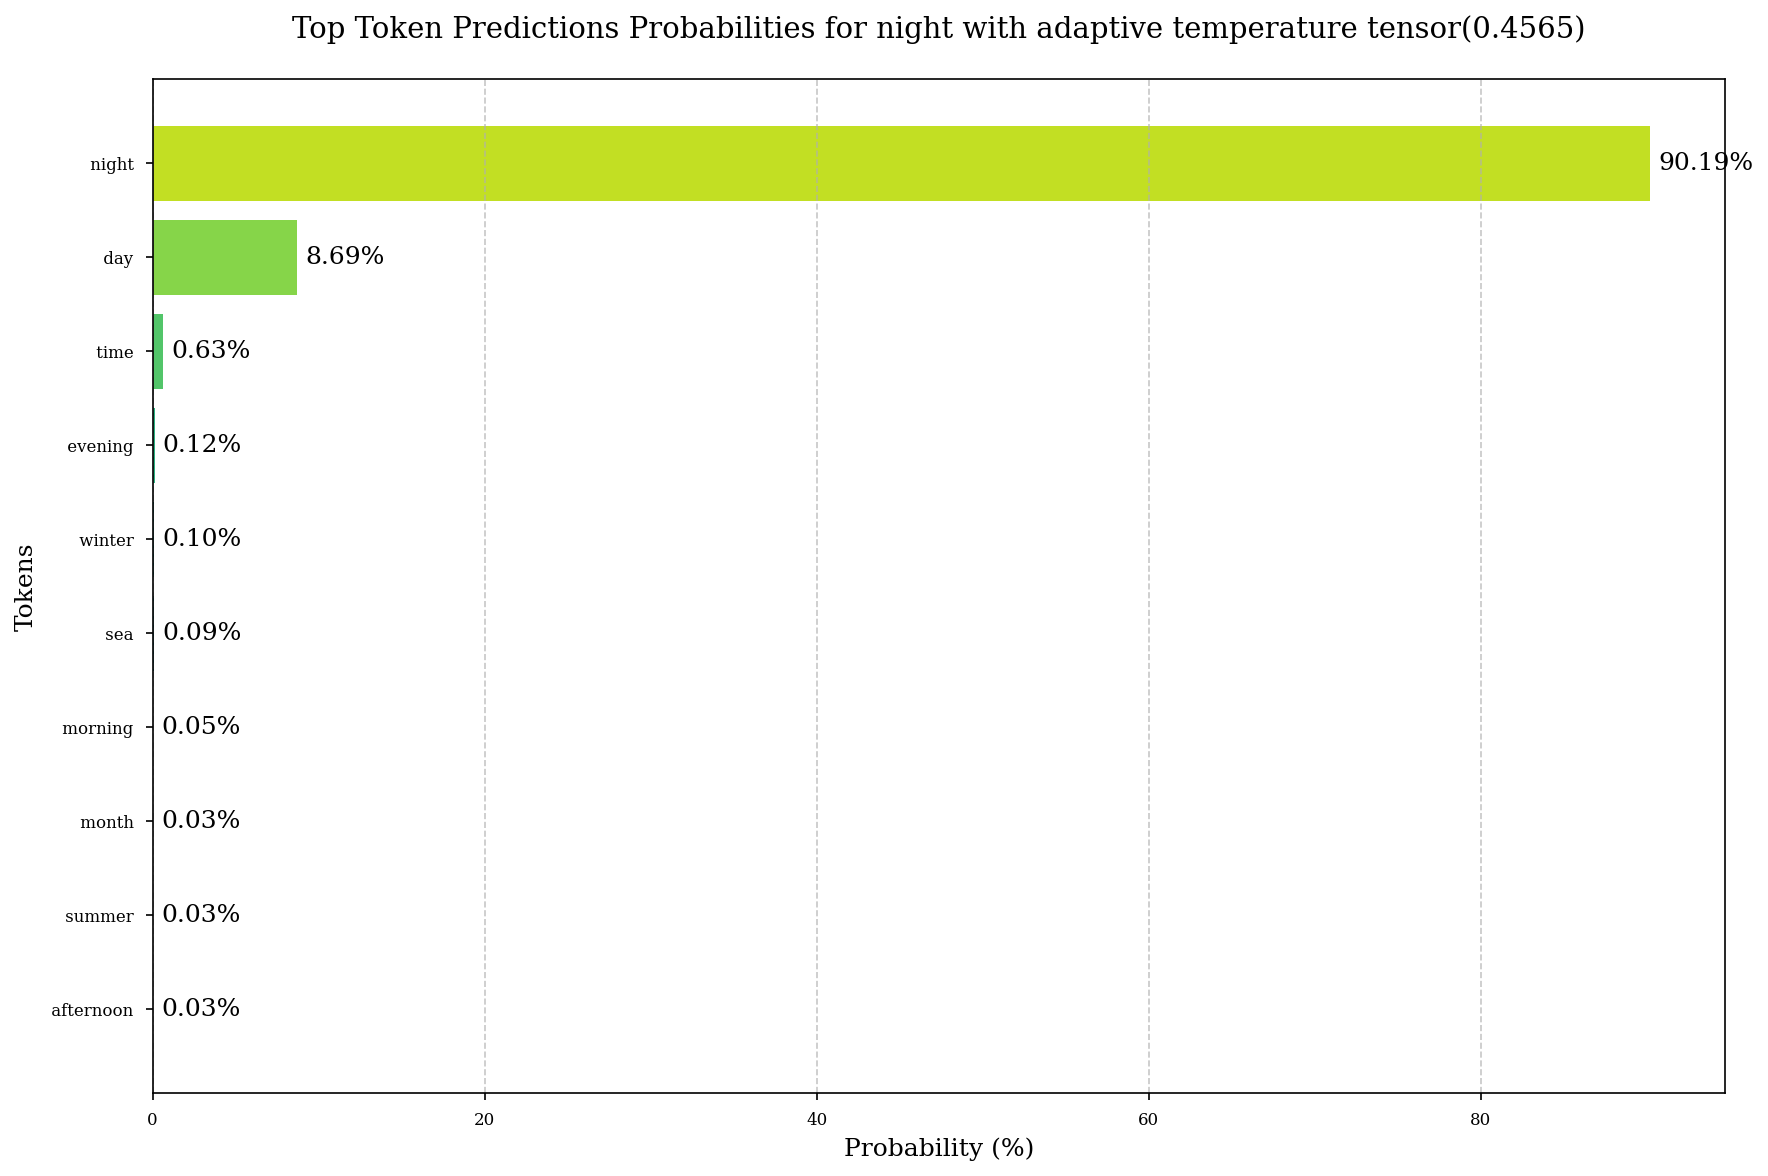

In [ ]:
mystery_token_logits = token_logits[5] #We select the second token.
token_data = []

#We get all the softmax probabilities in one batch thanks to the torch one liner
probs, temp = adaptive_temperature_softmax(mystery_token_logits)

#We iterate over all the tokens per id
for token_id in range(len(mystery_token_logits)):
    token = tokenizer.decode([token_id])
    logit = mystery_token_logits[token_id].item()
    prob = probs[token_id].item()
    token_data.append((token_id, token, logit, prob))

df_sorted = pd.DataFrame(token_data, columns=['Token ID', 'Token', 'Logit', 'Probs']).sort_values(by='Probs', ascending=False)
visualize_prob(df_sorted, title = 'Top Token Predictions Probabilities for night with adaptive temperature ' + str(temp))

Now let's try to generate some text with our new sampling strategy:

In [ ]:
def adaptive_temperature_softmax(logits):
    """
    Implement adaptive temperature softmax based on entropy
    """
    x = compute_entropy(torch.nn.functional.softmax(logits, dim=-1))
    beta = (poly_coeffs[0] * x**4 + poly_coeffs[1] * x**3 + poly_coeffs[2] * x**2 + poly_coeffs[3] * x + poly_coeffs[4])
    if x <= 0.5:
      beta = 1.0
    else:
      beta = max(beta, 1.0)
    adaptive_logits = torch.nn.functional.softmax(logits * beta, dim=-1)
    temperature = 1/beta
    return adaptive_logits, temperature

new_prediction_ids = input_ids
# Set the seeds
set_seeds(3)

cur_len = new_prediction_ids.shape[1]
while cur_len < max_length:
    with torch.no_grad():
        outputs = model(new_prediction_ids)

    #Extract the logits.
    next_token_logits = outputs.logits[:, -1, :]

    #Apply the temperature and the softmax
    probs, temp = adaptive_temperature_softmax(next_token_logits)

    # Get top_k tokens and their probabilities before sampling
    top_logits, top_indices = torch.topk(next_token_logits, top_tokens)

    # Sample the next token
    next_token = torch.multinomial(probs, num_samples=1)

    # Find the rank of the sampled token
    sorted_indices = torch.argsort(probs[0], descending=True)
    sampled_token_rank = (sorted_indices == next_token[0].item()).nonzero().item() + 1

    print(f"\nTop {top_tokens} candidates at position {cur_len}:")
    for logit, idx in zip(top_logits[0], top_indices[0]):
        token = tokenizer.decode([idx])
        prob = probs[0, idx].item()
        print(f"Token: '{token}', Probability: {prob:.4f}")

    # What was actually selected:
    print(f"\nSelected token: '{tokenizer.decode([next_token[0].item()])}' (Temperature {temp}, Rank: {sampled_token_rank})")

    # Add the new token to our sequence
    new_prediction_ids = torch.cat([new_prediction_ids, next_token], dim=-1)
    cur_len += 1

    print(f"Current text: {tokenizer.decode(new_prediction_ids[0])}")

print(f"\nFinal generated text:")
print(tokenizer.decode(new_prediction_ids[0]))


Top 5 candidates at position 8:
Token: ' the', Probability: 0.7132
Token: ' and', Probability: 0.2196
Token: ' it', Probability: 0.0219
Token: ' a', Probability: 0.0188
Token: ' I', Probability: 0.0107

Selected token: ' the' (Temperature 0.4166822135448456, Rank: 1)
Current text: It was a dark and stormy night; the

Top 5 candidates at position 9:
Token: ' moon', Probability: 0.3168
Token: ' sky', Probability: 0.1534
Token: ' sun', Probability: 0.1356
Token: ' wind', Probability: 0.0724
Token: ' stars', Probability: 0.0386

Selected token: ' sound' (Temperature 0.7060421705245972, Rank: 7)
Current text: It was a dark and stormy night; the sound

Top 5 candidates at position 10:
Token: ' of', Probability: 0.9377
Token: ' was', Probability: 0.0208
Token: ' and', Probability: 0.0043
Token: ' from', Probability: 0.0017
Token: ',', Probability: 0.0016

Selected token: ' was' (Temperature 1.0, Rank: 2)
Current text: It was a dark and stormy night; the sound was

Top 5 candidates at positio